Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2024./2025.  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2025 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **3. studenog 2024. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [439]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\Admin\miniconda3\envs\strojno_env\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['trace', 'poly']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [440]:
import numpy as np

def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [441]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [442]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

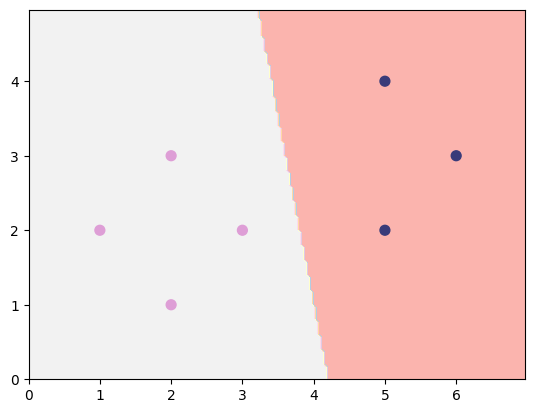

In [443]:
# Vaš kôd ovdj
model1a = RidgeClassifier(alpha=0)
model1a.fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, model1a.predict)
plt.show()

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

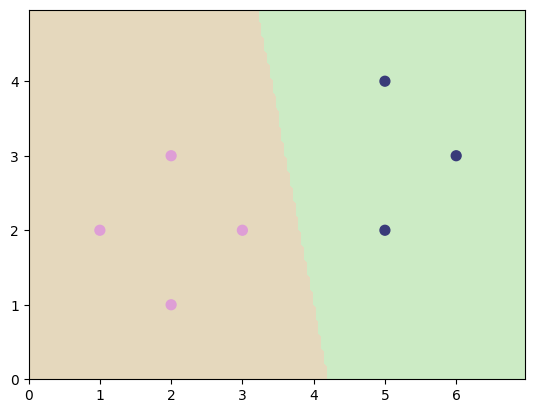

In [444]:
# Vaš kôd ovdje
model1a2 = LinearRegression()
model1a2.fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, lambda x: model1a2.predict(x) >= 0.5)
plt.show()

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [445]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

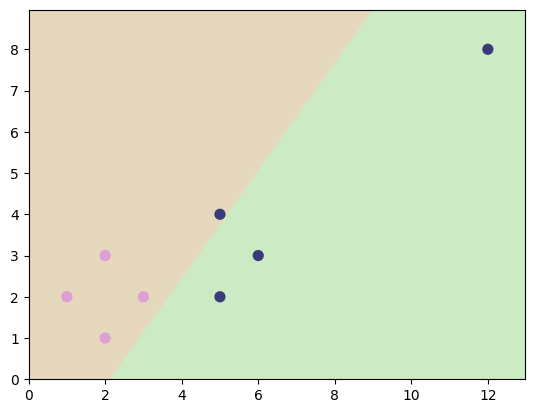

In [446]:
# Vaš kôd ovdje
model1b = RidgeClassifier(alpha=0)
model1b.fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, lambda x: model1b.predict(x) >= 0.5)
plt.show()

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [447]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

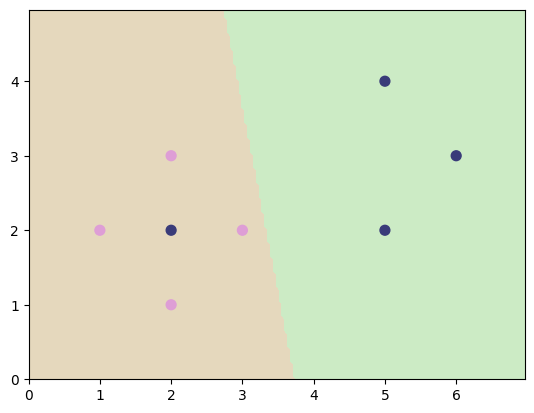

In [448]:
# Vaš kôd ovdje
model1c = RidgeClassifier(alpha=0)
model1c.fit(unsep_X, unsep_y)
plot_2d_clf_problem(unsep_X, unsep_y, lambda x: model1c.predict(x) >= 0.5)
plt.show()

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

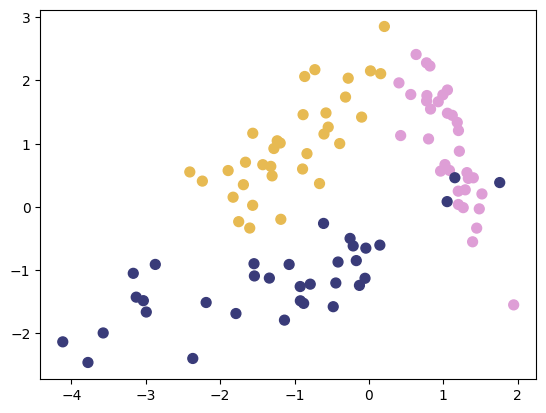

In [449]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
X2, y2 = make_classification(n_features=2, n_classes=3, n_redundant=0, n_clusters_per_class=1)
plot_2d_clf_problem(X2, y2)
plt.show()

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

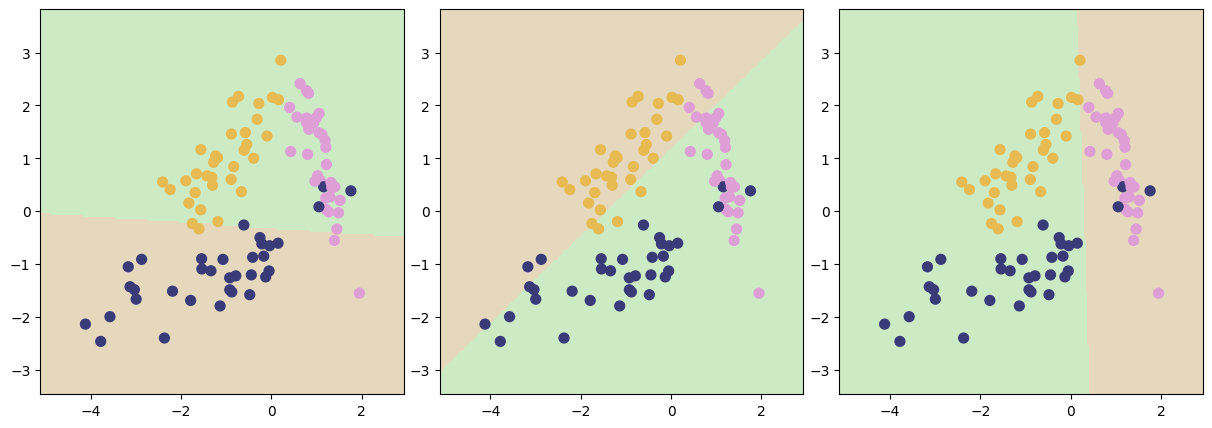

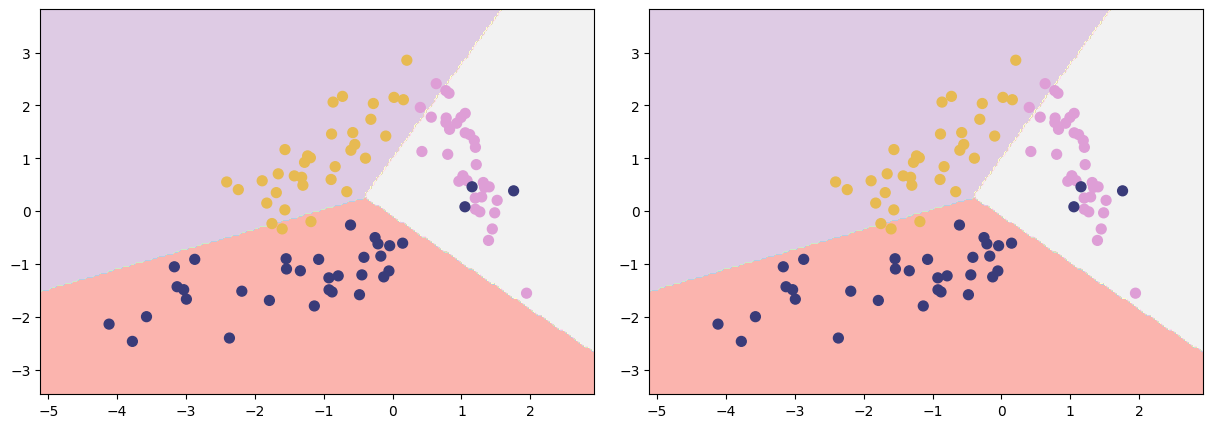

In [450]:
# Vaš kôd ovdje
from matplotlib.pyplot import subplot
from matplotlib.pyplot import subplots_adjust

h1 = [1 if i == 0 else 0 for i in y2]
h2 = [1 if i == 1 else 0 for i in y2]
h3 = [1 if i == 2 else 0 for i in y2]

plt.figure(figsize=(15,5))
subplots_adjust(wspace=0.1)

model21 = LinearRegression()
model21.fit(X2, h1)
subplot(1, 3, 1)
plot_2d_clf_problem(X2, y2, lambda x: model21.predict(x) >= 0.5)

model22 = LinearRegression()
model22.fit(X2, h2)
subplot(1, 3, 2)
plot_2d_clf_problem(X2, y2, lambda x: model22.predict(x) >= 0.5)

model23 = LinearRegression()
model23.fit(X2, h3)
subplot(1, 3, 3)
plot_2d_clf_problem(X2, y2, lambda x: model23.predict(x) >= 0.5)

def h(x):
   return np.argmax([model21.predict(x), model22.predict(x), model23.predict(x)], axis=0)
plt.figure(figsize=(15,5))
subplots_adjust(wspace=0.1)
subplot(1, 2, 1)
plot_2d_clf_problem(X2, y2, h)

model2 = RidgeClassifier(alpha=0)
model2.fit(X2, y2)
subplot(1, 2, 2)
plot_2d_clf_problem(X2, y2, model2.predict)



### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

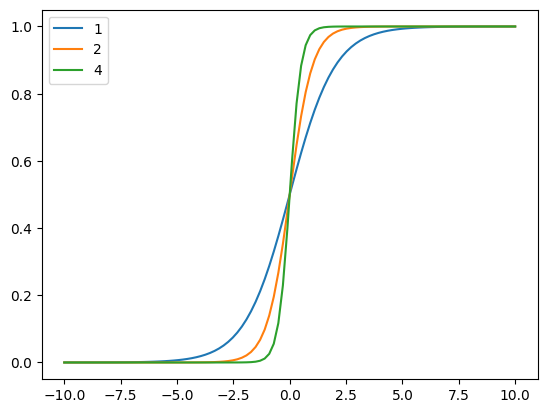

In [451]:
# Vaš kôd ovdje
def sigm(x, alpha=1):
   return 1/(1+np.exp(-alpha*x))
alphas = [1, 2, 4]
x = np.linspace(-10, 10, 100)
for alpha in alphas:
   plt.plot(x, sigm(x, alpha))
plt.legend(alphas)

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [452]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()

def cross_entropy_error(X, y, w):
    N = len(y)
    sum = 0
    for i in range(N):
        sum += -y[i]*np.log(sigm(w @ X[i])) - (1-y[i])*np.log(1-sigm(w @ X[i]))
    return sum/N

def lr_h(X, w):
    return sigm(w @ X.T)

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    Num, _ = X.shape
    poly = PolynomialFeatures(degree=1)
    phi_x = poly.fit_transform(X)
    D = phi_x.shape[1]
    w = np.zeros(D)
    all_weights = [] if trace else None
    previous_err = cross_entropy_error(phi_x, y, w)
    
    for i in range(max_iter):
        delta_w = np.zeros(D)

        for n in range(Num):
            h = lr_h(phi_x[n], w)
            delta_w -= (h - y[n]) * phi_x[n]
        # normalizacija gradijenta
        w[0] += eta * delta_w[0]
        # regularizacija
        w[1:] = w[1:] * (1 - eta * alpha) + eta * delta_w[1:]
        if trace:
            all_weights.append(w.copy())
        err = cross_entropy_error(phi_x, y, w)
        if np.abs(err - previous_err) <= epsilon:
            break
        previous_err = err
    return (w, np.array(all_weights)) if trace else w
        

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [453]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

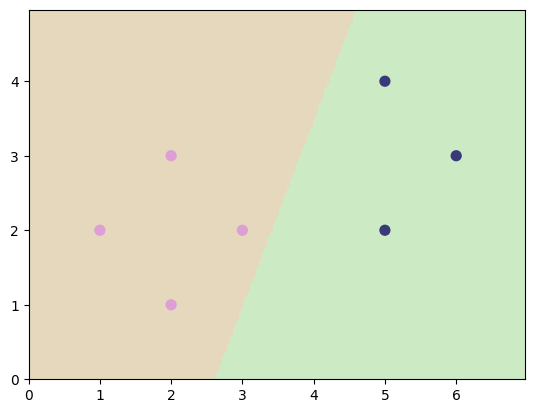

težine: [ 4.45449454 -1.71089242  0.68413507]
pogreška: 0.13521872720206746


In [454]:
w3c, trace3c = lr_train(seven_X, seven_y, trace=True)
plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(np.c_[np.ones(x.shape[0]), x], w3c) >= 0.5)
plt.show()
print("težine:", w3c)
print("pogreška:", cross_entropy_error(np.c_[np.ones(seven_X.shape[0]), seven_X], seven_y, w3c))


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [455]:
from sklearn.metrics import zero_one_loss

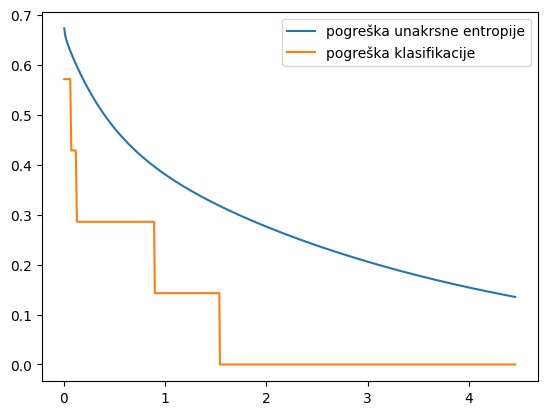

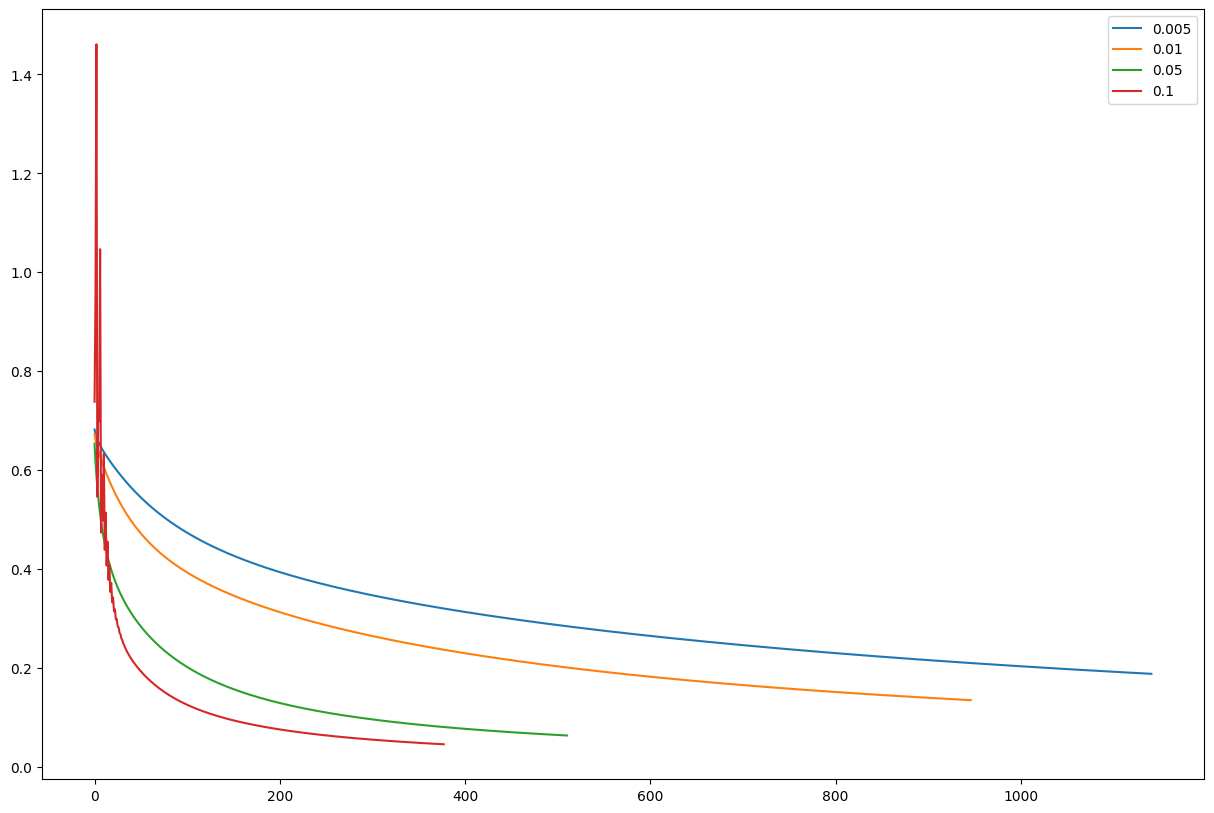

In [456]:
from sklearn.metrics import zero_one_loss

# na prvom grafu je prikazana pogreška unakrsne entropije i pogreška klasifikacije kroz iteracije optimizacijskog postupka
plt.plot(trace3c[:,0], [cross_entropy_error(np.c_[np.ones(seven_X.shape[0]), seven_X], seven_y, w) for w in trace3c])
plt.plot(trace3c[:,0], [zero_one_loss(seven_y, lr_h(np.c_[np.ones(seven_X.shape[0]), seven_X], w) >= 0.5) for w in trace3c])
plt.legend(["pogreška unakrsne entropije", "pogreška klasifikacije"])
plt.show()

#na drugom grafu je prikazana pogreška unakrsne entropije kao funkcija broja iteracija za različite vrijednosti parametra eta
etas = [0.005, 0.01, 0.05, 0.1]
plt.figure(figsize=(15,10))
for eta in etas:
   w3, trace3 = lr_train(seven_X, seven_y, eta=eta, trace=True)
   y = np.array([cross_entropy_error(np.c_[np.ones(len(seven_y)).T,seven_X], seven_y, i) for i in trace3])
   plt.plot(np.arange(len(y)), y)
plt.legend(etas)
plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

težine: [ 5.33129609 -1.18244419 -0.30251926]
pogreška: 2.220446049250313e-16


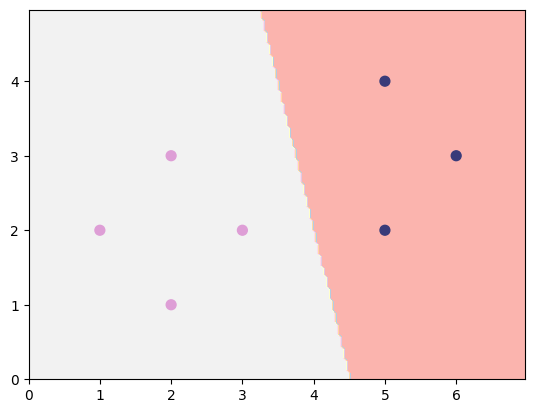

In [457]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# Vaš kôd ovdje
model3e = LogisticRegression()
model3e.fit(seven_X, seven_y)
print("težine:", np.insert(model3e.coef_, 0, model3e.intercept_[0]))
print("pogreška:", log_loss(seven_y, model3e.predict(seven_X) >= 0.5))
plot_2d_clf_problem(seven_X, seven_y, model3e.predict)

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [458]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

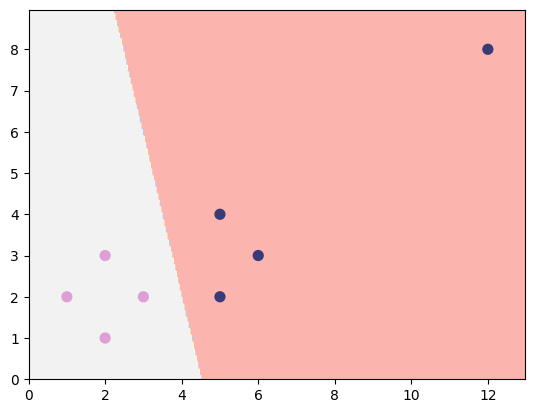

In [459]:
# Vaš kôd ovdje
model4a = LogisticRegression()
model4a.fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, model4a.predict)


**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

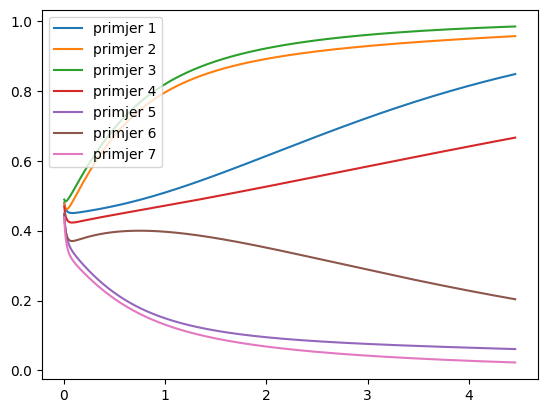

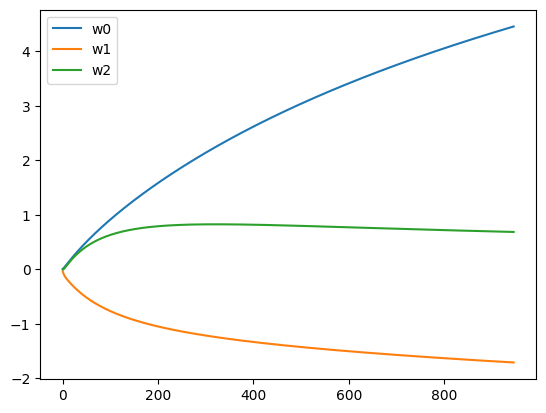

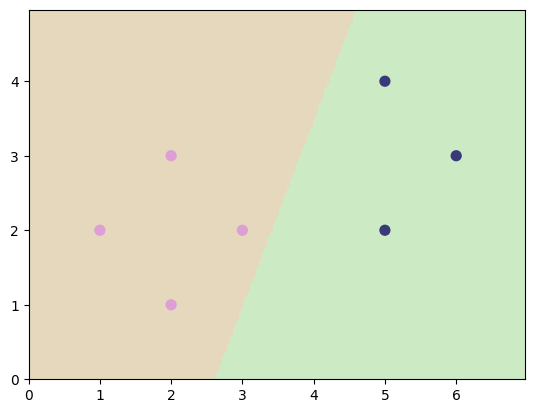

In [460]:
# Vaš kôd ovdje
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

w4b, trace4b = lr_train(seven_X, seven_y, trace=True)
iterations = range(len(trace4b))
for i in range(7):
   plt.plot(trace4b[:,0], [sigm(np.dot(np.insert(seven_X[i], 0, 1), w4b)) for w4b in trace4b])
plt.legend([f"primjer {i+1}" for i in range(7)])
plt.show()

for i in range(3):
   plt.plot(iterations, [w4b[i] for w4b in trace4b])
plt.legend(["w0", "w1", "w2"])
plt.show()

plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(np.c_[np.ones(x.shape[0]), x], w4b) >= 0.5)


### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [461]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

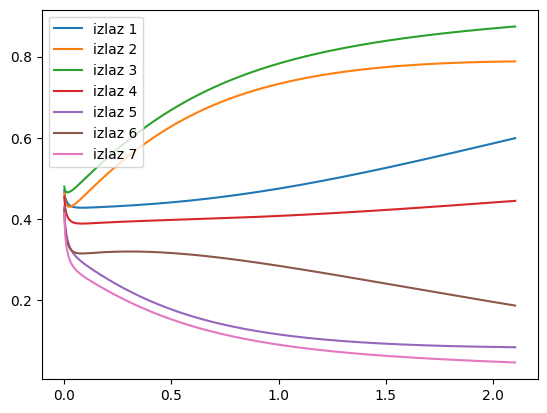

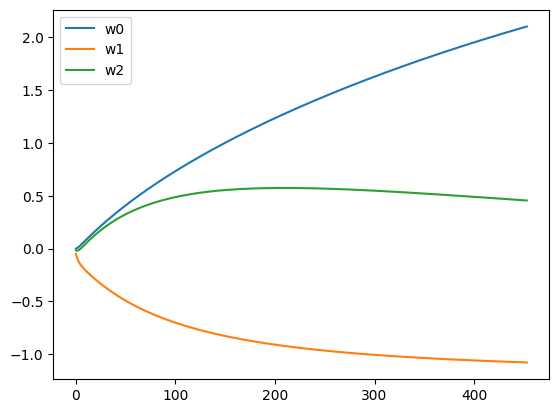

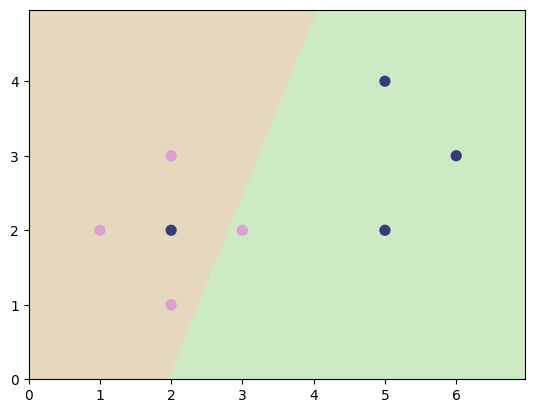

In [462]:
# Vaš kôd ovdje
w4c, trace4c = lr_train(unsep_X, unsep_y, trace=True)
iterations = range(len(trace4c))
for i in range(7):
   plt.plot(trace4c[:,0], [sigm(np.dot(np.insert(unsep_X[i], 0, 1), w4c)) for w4c in trace4c])
plt.legend([f"izlaz {i+1}" for i in range(7)])
plt.show()
for i in range(3):
   plt.plot(iterations, [w4c[i] for w4c in trace4c])
plt.legend(["w0", "w1", "w2"])
plt.show()

plot_2d_clf_problem(unsep_X, unsep_y, lambda x: lr_h(np.c_[np.ones(x.shape[0]), x], w4c) >= 0.5)

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [463]:
from numpy.linalg import norm

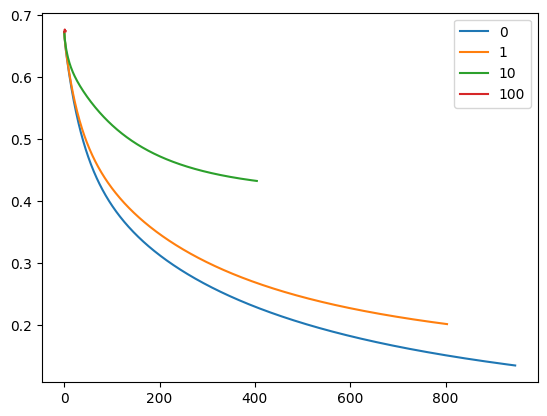

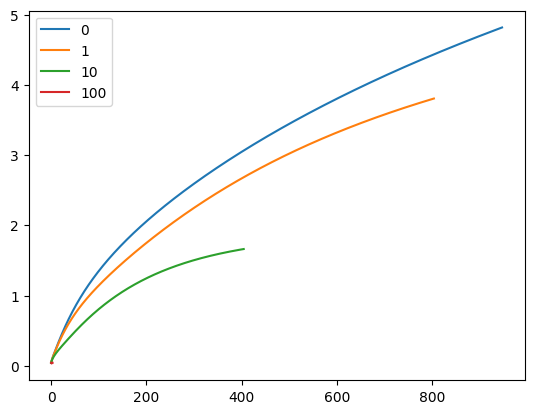

In [464]:
# Vaš kôd ovdje
alphas = [0, 1, 10, 100]
for i in range(len(alphas)):
    w5, trace5 = lr_train(seven_X, seven_y, alpha=alphas[i], trace=True)
    iterations5 = range(len(trace5))
    plt.plot(iterations5, [cross_entropy_error(np.c_[np.ones(seven_X.shape[0]), seven_X], seven_y, w5) for w5 in trace5])
plt.legend(alphas)
plt.show()

for i in range(len(alphas)):
    w51, trace51 = lr_train(seven_X, seven_y, alpha=alphas[i], trace=True)
    iterations51 = range(len(trace51))
    plt.plot(iterations51, [norm(w51) for w51 in trace51])
plt.legend(alphas)
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [465]:
from sklearn.preprocessing import PolynomialFeatures

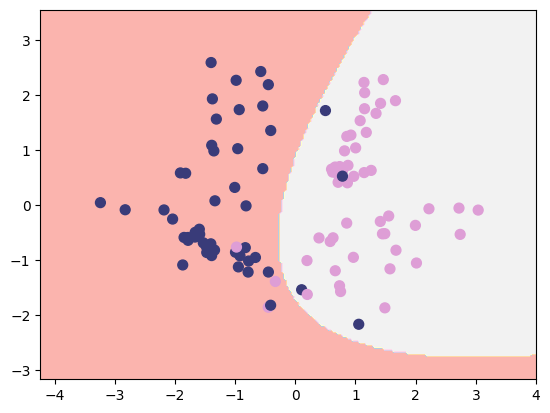

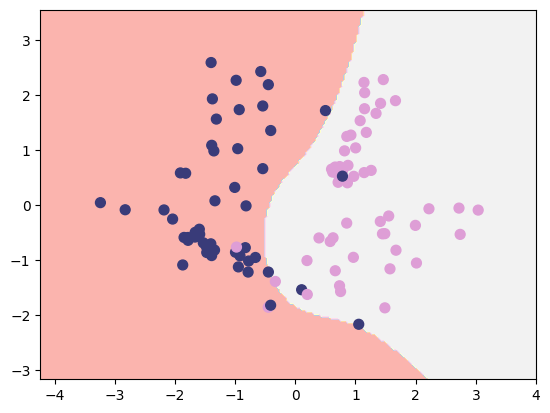

In [466]:
from sklearn.datasets import make_classification
# Vaš kôd ovdje
from sklearn.preprocessing import PolynomialFeatures

poly6 = PolynomialFeatures(degree=2)
X6, y6 = make_classification(n_samples=100, n_features=2,n_classes=2, n_redundant=0, n_clusters_per_class=2)
model6 = LogisticRegression().fit(poly6.fit_transform(X6), y6)
plot_2d_clf_problem(X6, y6, lambda x : model6.predict(poly6.transform(x)))
plt.show()

poly62 = PolynomialFeatures(degree=3)
model62 = LogisticRegression().fit(poly62.fit_transform(X6), y6)
plot_2d_clf_problem(X6, y6, lambda x : model62.predict(poly62.transform(x)))
plt.show()



**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?